<a href="https://colab.research.google.com/github/wilmeragsgh/term_freq_linkedin/blob/master/Term_frequency_of_followers'_positions_over_time_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#@title **Text preprocessing aux functions**
import re
from gensim.utils import deaccent
from nltk.corpus import stopwords
import nltk
import string
nltk.download('stopwords')

class Preprocessor(object):
    def __init__(self,custom_stopwords=None):
        self.stopwords = stopwords.words('english') + stopwords.words('spanish')
        if custom_stopwords:
            self.stopwords += custom_stopwords
        self.punctuation = string.punctuation +'¿¡|'
        self.pipeline = [
            self.__remove_quotes,
            self.__remove_accent,
            self.__tokenize,
            self.__remove_punctuation,
            self.__remove_stopwords
        ]
        
    def __remove_quotes(self, text):
        # Remove distracting single quotes
        return [re.sub("\'", "", tweet) for tweet in text]
    
    def __remove_accent(self, text):
        # Remove accents
        return [deaccent(tweet).lower() for tweet in text]
    
    def __remove_punctuation(self, text):
        return [[word.translate(str.maketrans('', '', self.punctuation)) for word in tweet] for tweet in text]
    
    def __tokenize(self, text):
        # Tokenize
        return [tweet.split(' ') for tweet in text]

    def __remove_stopwords(self, text):
        # Removing stopwords
        return [[word for word in tweet if word not in self.stopwords] for tweet in text]
    
    def transform(self, text):
        for op in self.pipeline:
            text = op(text)
        return text

prep = Preprocessor()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#@title **Upload file**
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('You uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

import pandas as pd
connections = pd.read_csv(fn)
connections.head()

Saving Connections.csv to Connections (2).csv
You uploaded file "Connections.csv" with length 100377 bytes


,First Name,Last Name,Email Address,Company,Position,Connected On
0,Baudimar,Calvete,NaN,Independiente,Adminitracion de recursos humanos,14 Jan 2020
1,Monica,Perez,NaN,Fetcher,Specialist II,13 Jan 2020
2,Sam,Mbende,NaN,RealEstate,invistment,12 Jan 2020
3,Jehosafat,Becerra,NaN,"freelancer, author, journalist",Escritor autónomo,09 Jan 2020
4,Eduardo,Espinoza,NaN,CGTS Corp Inc,Desarrollador de software,08 Jan 2020


In [0]:
#@title **Preprocessing step**
from datetime import datetime as dtime
connections['Connected On_parsed'] = connections.apply(lambda row: dtime.strptime(row['Connected On'],'%d %b %Y'), axis = 1)
connections['MonthDate'] = connections['Connected On_parsed'].dt.strftime('%Y-%m')
connections_filtered = connections[['Position','MonthDate']]
connections_filtered = connections_filtered[connections_filtered['Position'].notnull()]
## Filtering null positions and keeping only position and month/date ^
connections_names = pd.DataFrame(columns=["Position_term","MonthDate"],
                                 index=[0])
for ix, row in connections_filtered.iterrows():
    for wrd in prep.transform([row.Position])[0]:
        if wrd == '':
            continue
        connections_names = connections_names.append(
            {
                "Position_term": wrd,
                "MonthDate": row['MonthDate']
            },
            ignore_index=True
        )

connections_names = connections_names.dropna()
group_dates = pd.DataFrame(connections_names.groupby(['MonthDate',
                                                      'Position_term']).size())
group_dates = group_dates.reset_index()
group_dates.columns = ['MonthDate','Position_term','Freq']
group_dates.sort_values(by=['MonthDate','Freq'],ascending=False)
## Generating an entry for each term in the data for example 'full stack dev'
## -> 'full' , 'stack', 'dev' (for the same month/date) ^
del connections
del connections_filtered
del connections_names
## Deleting temporal vars ^
import numpy as np
monthdates_arr = []
for yearn in range(2013,2020):
    for monthn in range(1,13):
        if yearn == 2013 and monthn < 4:
            continue
        if monthn < 10:
            monthdates_arr.append(str(yearn) + '-0' +str(monthn))
        else:
            monthdates_arr.append(str(yearn) + '-' +str(monthn))
position_dates = []
for ix, row in group_dates.iterrows():
    position_dates.append(row.Position_term + row.MonthDate)
position_dates = np.unique(position_dates)
## Utility functions ^
for term in np.unique(group_dates['Position_term'].tolist()):
    for monthdate in monthdates_arr:
        if  term + monthdate not in position_dates:
            group_dates = group_dates.append({"Position_term":term,
                                              "MonthDate":monthdate,
                                              "Freq":0},ignore_index=True)
group_dates.head()
## Fulfilling values of monts that are not present ^
group_dates_acum_filled_missing_months = group_dates.groupby(by=['Position_term','MonthDate']).sum().groupby(level=[0]).cumsum()
group_dates_acum_filled_missing_months = group_dates_acum_filled_missing_months.reset_index()
## Acumulating values for expressivenes of the rows ^
#test_for_position_name = group_dates_acum_filled_missing_months[group_dates_acum_filled_missing_months['Position_term'] == 'developer']
#test_for_position_name.head(30)
## For testing that everything is ok

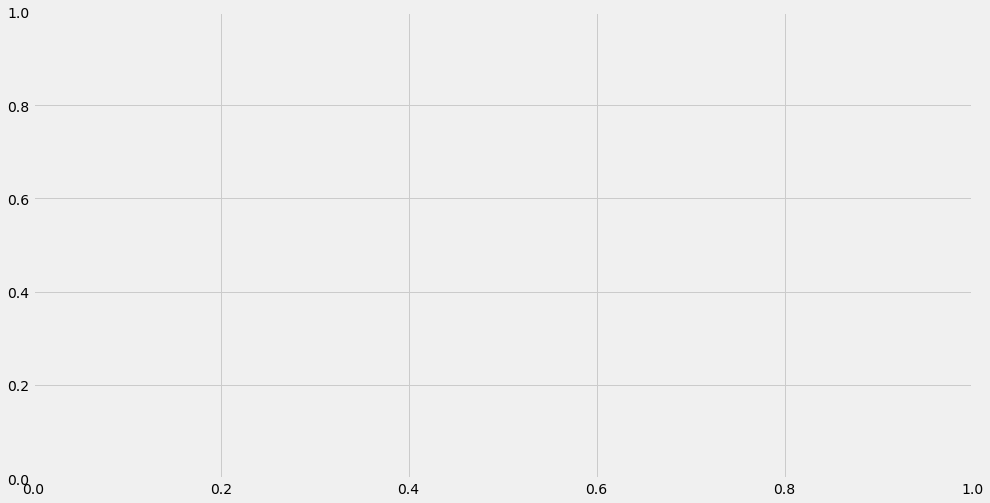

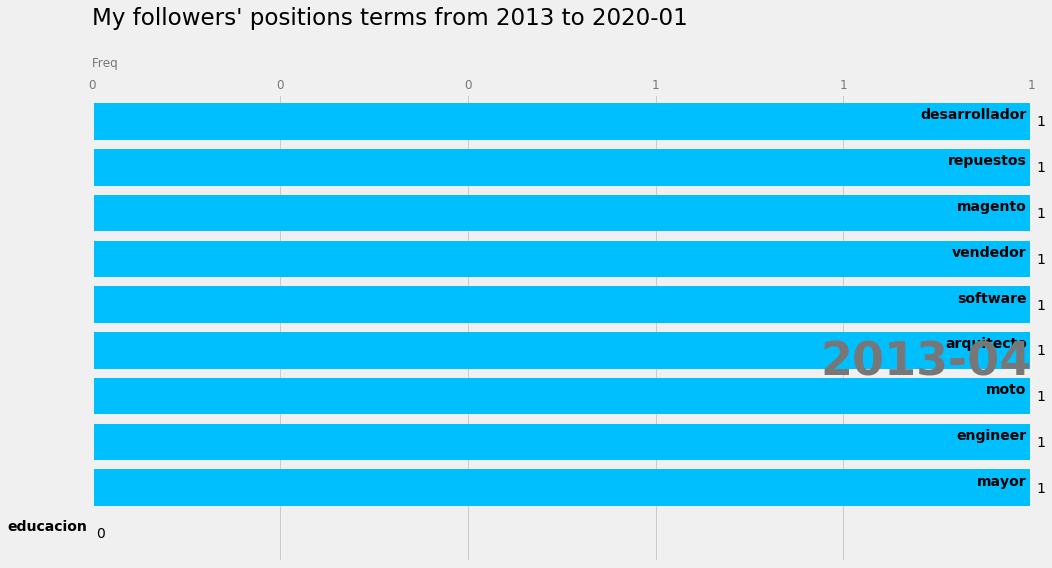

In [32]:
#@title **Generation of the plot**
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.style as style
style.available
style.use('fivethirtyeight')

value_of_output_file = 'output'  #@param {type: "string"} 
value_of_output_file = value_of_output_file + '.mp4'
fps = 1  #@param {type: "number"}
dpi = 200 #@param {type: "number"}

fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(monthdate):
    dff = group_dates_acum_filled_missing_months[group_dates_acum_filled_missing_months['MonthDate'].eq(monthdate)].sort_values(by='Freq', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['Position_term'], dff['Freq'], color=['#00BFFF'])
    dx = dff['Freq'].max() / 200  
    # zip function use iterable objects to format the axes 
    for i, (value, name) in enumerate(zip(dff['Freq'], dff['Position_term'])):
        ax.text(value-dx, 
                i, 
                name, 
                size=14, 
                weight=600, 
                ha='right', 
                va='bottom')
        ax.text(value+dx, 
                i, 
                f'{value:,.0f}', 
                size=14, 
                ha='left', 
                va='center')
   
    # polished styles
    ax.text(1, 0.4, monthdate, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Freq', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.02)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, "My followers' positions terms from 2013 to 2020-01",
            transform=ax.transAxes, size=23, weight=500, ha='left')
    ##add some notation
    #ax.text(1, 0, 'Data sources: FivethirtyEight @ZoeZ', transform=ax.transAxes, ha='right',
    #         color='#577777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#plt.box(False)

fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart,frames=monthdates_arr)
# .save as gif or mp4 fps is the speed and dpi is the resolution # previously -> fps=.5
animator.save(value_of_output_file, fps=fps, dpi=dpi)